In [306]:
import random
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import cross_val_predict, train_test_split
from sklearn.metrics import accuracy_score

from cleanlab.filter import find_label_issues
from cleanlab.classification import CleanLearning
from cleanlab import Datalab

from sklearn.model_selection import RepeatedStratifiedKFold, cross_val_score, StratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.ensemble import RandomForestClassifier

from sklearn.inspection import permutation_importance

from pathlib import Path

SEED = 100

np.random.seed(SEED)
random.seed(SEED)

In [332]:
CKD_INDIA_PATH = Path("../data/Public_Datasets/CKD_UAE_Dataset/ChronicKidneyDisease_EHRs_from_AbuDhabi.csv")
df = pd.read_csv(CKD_INDIA_PATH)

df = df.drop(columns=["TIME_YEAR", "TimeToEventMonths"])
df.head()

,Sex,AgeBaseline,HistoryDiabetes,HistoryCHD,HistoryVascular,HistorySmoking,HistoryHTN,HistoryDLD,HistoryObesity,DLDmeds,DMmeds,HTNmeds,ACEIARB,CholesterolBaseline,CreatinineBaseline,eGFRBaseline,sBPBaseline,dBPBaseline,BMIBaseline,EventCKD35
0,0,64,0,0,0,0,1,1,1,1,0,1,0,4.8,59.0,93.3,144,87,40,0
1,0,52,0,0,0,0,1,1,1,0,0,1,0,6.4,52.0,105.8,148,91,45,0
2,0,56,0,0,0,0,1,1,1,1,0,1,0,6.4,57.0,99.8,149,86,41,0
3,0,58,0,0,0,0,0,1,1,1,0,0,0,5.1,65.0,90.3,116,68,32,0
4,0,63,1,0,0,0,1,1,1,1,1,1,1,5.0,70.0,79.7,132,63,31,0


In [333]:
y = df.EventCKD35.copy()
X = df.drop(columns=["EventCKD35"]).copy()

In [334]:
# define pipeline
steps = [('over', SMOTE()), ('model', RandomForestClassifier())]
pipeline = Pipeline(steps=steps)
# evaluate pipeline
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
scores = cross_val_score(pipeline, X, y, scoring='roc_auc', cv=cv, n_jobs=-1)
print('Mean ROC AUC: %.3f' % np.mean(scores))

Mean ROC AUC: 0.852


In [335]:
# define model
clf = RandomForestClassifier()

# evaluate pipeline
cv = StratifiedKFold(n_splits=10, random_state=1, shuffle=True)

pred_probs = cross_val_predict(
    clf,
    X,
    y,
    cv=cv,
    method="predict_proba",
)

In [336]:
data = {"X": X.values, "y": y.values}

In [337]:
lab = Datalab(data, label_name="y")
lab.find_issues(pred_probs=pred_probs, features=data["X"])

Finding label issues ...
Finding outlier issues ...
Fitting OOD estimator based on provided features ...
Finding near_duplicate issues ...
Finding non_iid issues ...

Audit complete. 50 issues found in the dataset.


In [338]:
lab.report()

Here is a summary of the different kinds of issues found in the data:

    issue_type  num_issues
       outlier          30
         label          19
       non_iid           1
near_duplicate           0

Dataset Information: num_examples: 491, num_classes: 2


---------------------- outlier issues ----------------------

About this issue:
	Examples that are very different from the rest of the dataset 
    (i.e. potentially out-of-distribution or rare/anomalous instances).
    

Number of examples with this issue: 30
Overall dataset quality in terms of this issue: 0.9977

Examples representing most severe instances of this issue:
     is_outlier_issue  outlier_score
236              True       0.952711
471              True       0.988955
217              True       0.991504
129              True       0.991588
394              True       0.991656


----------------------- label issues -----------------------

About this issue:
	Examples whose given label is estimated to be potential

In [339]:
outlier_results = lab.get_issues("outlier")
sorted_outliers= outlier_results.sort_values("outlier_score").index

df.iloc[sorted_outliers][:30]

,Sex,AgeBaseline,HistoryDiabetes,HistoryCHD,HistoryVascular,HistorySmoking,HistoryHTN,HistoryDLD,HistoryObesity,DLDmeds,DMmeds,HTNmeds,ACEIARB,CholesterolBaseline,CreatinineBaseline,eGFRBaseline,sBPBaseline,dBPBaseline,BMIBaseline,EventCKD35
236,1,74,1,0,1,0,1,1,0,1,1,1,1,3.00,6.0,242.6,120,80,27,0
471,1,62,1,1,0,0,1,1,0,1,1,1,1,2.40,106.0,64.5,92,54,29,1
217,0,31,0,0,0,0,1,0,1,0,0,0,0,5.60,49.0,125.1,100,95,30,0
129,0,59,0,0,0,0,1,1,1,1,0,1,0,4.80,27.0,125.0,104,67,30,0
394,1,89,0,0,0,0,1,1,0,1,0,1,1,2.90,86.0,68.7,110,63,27,1
401,1,56,0,0,1,1,1,0,0,0,0,1,1,3.00,29.0,144.1,160,97,13,0
429,1,69,1,1,0,0,1,1,1,1,1,1,0,4.00,88.0,76.9,119,41,30,0
64,0,48,0,0,0,0,0,1,1,0,0,0,0,6.30,46.0,113.3,95,45,30,0
435,1,36,1,0,0,1,1,1,1,1,0,1,0,5.70,97.0,86.2,163,110,39,0
48,1,45,0,0,0,0,1,1,1,1,0,1,1,6.80,123.0,60.7,133,74,33,0


In [340]:
#X = X.drop([459, 236, 55, 394, 471, 64])
#y = y.drop([459, 236, 55, 394, 471, 64])

In [341]:
X = X.drop(sorted_outliers[:30])
y = y.drop(sorted_outliers[:30])

In [317]:
# values to evaluate
k_values = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
for k in k_values:
    # define pipeline
    model = RandomForestClassifier()
    over = SMOTE(sampling_strategy=0.5, k_neighbors=k)
    steps = [('over', over), ('model', model)]
    pipeline = Pipeline(steps=steps)
    # evaluate pipeline
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=5, random_state=1)
    scores = cross_val_score(pipeline, X, y, scoring='roc_auc', cv=cv, n_jobs=-1)
    score = np.mean(scores)
    print('> k=%d, Mean ROC AUC: %.3f' % (k, score))

> k=1, Mean ROC AUC: 0.822
> k=2, Mean ROC AUC: 0.821
> k=3, Mean ROC AUC: 0.823
> k=4, Mean ROC AUC: 0.823


KeyboardInterrupt: 

In [345]:
steps = [('over', SMOTE()), ('model', RandomForestClassifier(**best_params))]
pipeline = Pipeline(steps=steps)

pipeline.fit(X,y)

Pipeline(steps=[('over', SMOTE()),
                ('model',
                 RandomForestClassifier(max_depth=90, min_samples_leaf=2,
                                        min_samples_split=5,
                                        n_estimators=400))])

<Axes: ylabel='cols'>

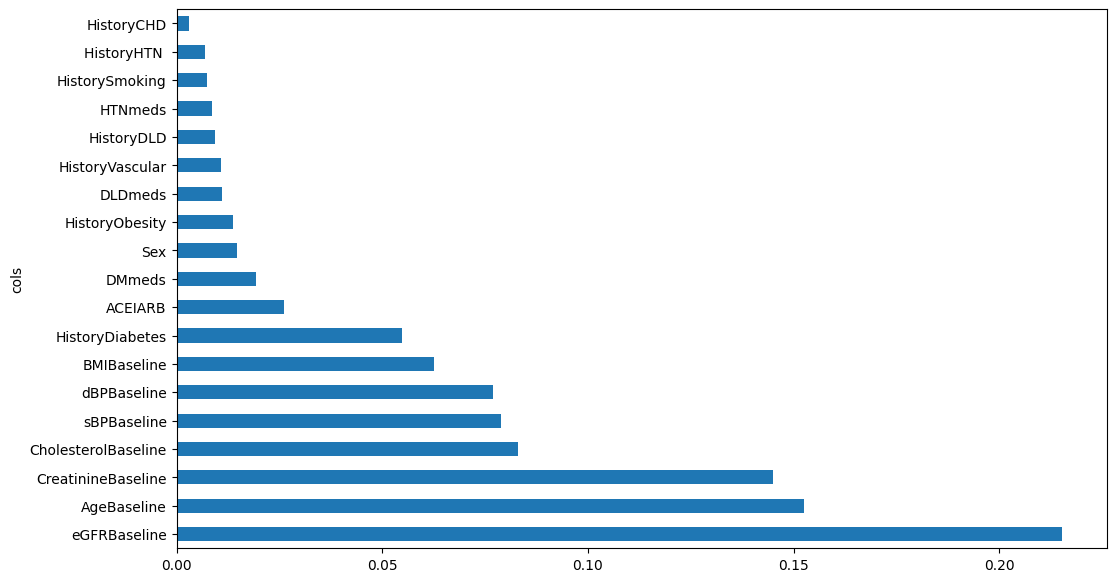

In [346]:
def rf_feat_importance(m):
    return pd.DataFrame({'cols':m.feature_names_in_, 'imp':m.feature_importances_}
                       ).sort_values('imp', ascending=False)
    
rf_feat_importance(pipeline.named_steps['model']).plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)

In [ ]:
from sklearn.model_selection import RandomizedSearchCV# Number of trees in random forest
n_estimators_values = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features_values = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth_values = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth_values.append(None)
# Minimum number of samples required to split a node
min_samples_split_values = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf_values = [1, 2, 4]

In [ ]:
# Initialize variables to store the best configuration and accuracy
best_params = {}
best_score = 0.0

# Loop over hyperparameter combinations
for n_estimators in n_estimators_values:
    for max_depth in max_depth_values:
        for min_samples_split in min_samples_split_values:
            for min_samples_leaf in min_samples_leaf_values:
                # Create Random Forest classifier with current hyperparameters
                rf_classifier = RandomForestClassifier(
                    n_estimators=n_estimators,
                    max_depth=max_depth,
                    min_samples_split=min_samples_split,
                    min_samples_leaf=min_samples_leaf,
                    random_state=42
                )
                # define pipeline
                model = RandomForestClassifier()
                over = SMOTE(sampling_strategy=0.5, k_neighbors=1)
                steps = [('over', over), ('model', model)]
                pipeline = Pipeline(steps=steps)
                # evaluate pipeline
                cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
                scores = cross_val_score(pipeline, X, y, scoring='roc_auc', cv=cv, n_jobs=-1)
                score = np.mean(scores)

                # Display results
                print(f"Parameters: {{'n_estimators': {n_estimators}, 'max_depth': {max_depth}, 'min_samples_split': {min_samples_split}, 'min_samples_leaf': {min_samples_leaf}}}")
                print(f"ROC AUC: {score}\n")

                # Update best configuration if current model is better
                if score > best_score:
                    best_score = score
                    best_params = {
                        'n_estimators': n_estimators,
                        'max_depth': max_depth,
                        'min_samples_split': min_samples_split,
                        'min_samples_leaf': min_samples_leaf
                    }

# Display the best configuration and accuracy
print("Best Parameters:", best_params)
print("Best Accuracy:", best_score)


Parameters: {'n_estimators': 200, 'max_depth': 10, 'min_samples_split': 2, 'min_samples_leaf': 1}
ROC AUC: 0.8505149051490516

Parameters: {'n_estimators': 200, 'max_depth': 10, 'min_samples_split': 2, 'min_samples_leaf': 2}
ROC AUC: 0.8506368563685637

Parameters: {'n_estimators': 200, 'max_depth': 10, 'min_samples_split': 2, 'min_samples_leaf': 4}
ROC AUC: 0.8567479674796749

Parameters: {'n_estimators': 200, 'max_depth': 10, 'min_samples_split': 5, 'min_samples_leaf': 1}
ROC AUC: 0.8592411924119241

Parameters: {'n_estimators': 200, 'max_depth': 10, 'min_samples_split': 5, 'min_samples_leaf': 2}
ROC AUC: 0.8521815718157183

Parameters: {'n_estimators': 200, 'max_depth': 10, 'min_samples_split': 5, 'min_samples_leaf': 4}
ROC AUC: 0.8505555555555556

Parameters: {'n_estimators': 200, 'max_depth': 10, 'min_samples_split': 10, 'min_samples_leaf': 1}
ROC AUC: 0.8518563685636857

Parameters: {'n_estimators': 200, 'max_depth': 10, 'min_samples_split': 10, 'min_samples_leaf': 2}
ROC AUC: 0.

KeyboardInterrupt: 

In [344]:
best_params

{'n_estimators': 400,
 'max_depth': 90,
 'min_samples_split': 5,
 'min_samples_leaf': 2}